# Lab3. Pytorch Classification (Logistic Regression vs MLP)  

이 실습에서는 Classification Problem을 `pytorch`로 해결해볼 겁니다! 두가지 모델(Linear Regression, MLP)을 둘 다 구현해보고 모델이 생각하는 데이터 분포를 시각화해서 MLP가 실제로 non-linear Decision-Boundary를 가질 수 있는지 살펴보는게 본 실습의 묘미입니다.


**이 문서를 구글 Colab에서 쉽게 실행해보는법**  
1. [제가 미리 만들어놓은 이 링크](https://colab.research.google.com/github/heartcored98/Standalone-DeepLearning/blob/master/Lec2/Lab3_pytorch_classification_demo.ipynb)를 눌러 본 .ipynb 파일을 구글 Colab에서 바로 열 수 있습니다. 이때 구글에 로그인을 해야 합니다.
2. 아무 셀이나 선택한 후 `Ctrl+Enter`를 눌러 실행해보면 **[경고: 이 노트는 Google에서 작성하지 않았습니다]**라고 뜨는데 `실행 전에 모든 런타임 재설정`을 선택한 채로 `무시하고 계속하기`를 눌러줍니다.  
3. **[모든 런타임 재설정]** 이 뜰 텐데 `예`를 눌러줍니다.  
4. 잠시 구글 서버의 배치가 되면서 우상단에 `연결중` -> `초기화중` -> `연결됨`이 뜨면서 실행이 가능한 상태가 됩니다.  

**이 문서를 구글 Colab에서 어렵게 실행해보는법**  
1. 구글 Colab 문서를 하나 만들어줍시다. 
2. 본 문서에 있는 셀에 있는 코드를 드래그 한 후 `Ctrl+C`를 눌러줍시다.  
3. 구글 Colab 문서에 가서 `Ctrl+V`를 눌러줍시다.
4. 모든 셀이 다 복사될 때까지 1~3 무한반복!  

**구글 Colab에서 실습후 저장하는법**  
**쉽게 실행보는법**을 따라오셨다면 Colab에서 임시 노트북으로 열리기 때문에 `파일`->`드라이브로 저장`을 눌러서 여러분의 구글 드라이브에 저장하거나 `파일` -> `.ipynb 다운로드`를 눌러서 다운로드 해줍시다.   

*Written by. 조재영(whwodud9@kaist.ac.kr) 2019.01.20 *

In [ ]:
"""#구글 Colab에서 실행할 때는 이 주석을 해제하시고 실행해서 pytorch 1.0을 깔아주세요!
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)
"""

### 1. Data Generation  (Preparation)

Classification 실습에 사용할 데이터를 만들어봅시다. 이번에도 X가 2차원 Y가 1차원인 상황입니다. X는 모두 continuous space에 존재하고 Y는 class이기 때문에 discrete space에 분포합니다. `sklearn` 패키지에서 제공하는 `moon` 분포를 활용해서 Logistic 모델과 MLP 모델이 잘 분류할 수 있는지 테스트해봅시다.

`make_moons()` 함수를 실행하면 아래와 같이 x1, x2에 대해서 반달 모양으로 서로 맞닿아 있는 분포가 그려집니다.  

**Data Set**  
$$X_{train} \in \mathcal{R}^{8000 \times 2}, Y_{train} \in \mathcal{Z}^{8000}$$  
$$X_{val} \in \mathcal{R}^{1000 \times 2}, Y_{val} \in \mathcal{Z}^{1000}$$  
$$X_{test} \in \mathcal{R}^{1000 \times 2}, Y_{test} \in \mathcal{Z}^{1000}$$

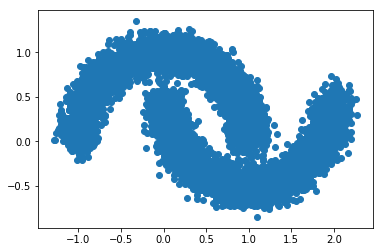

In [43]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(10000, noise=0.1, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

이제 이걸 조금 변형해서 총 4개의 클래스가 반달 모양으로 연결되어 있는 데이터 분포를 만들어보고 클래스 별로 다르게 그려봅시다.  
총 네 개의 클래스가 2차원 공간에 분포하고 있네요~!

(10000, 2) (10000,)


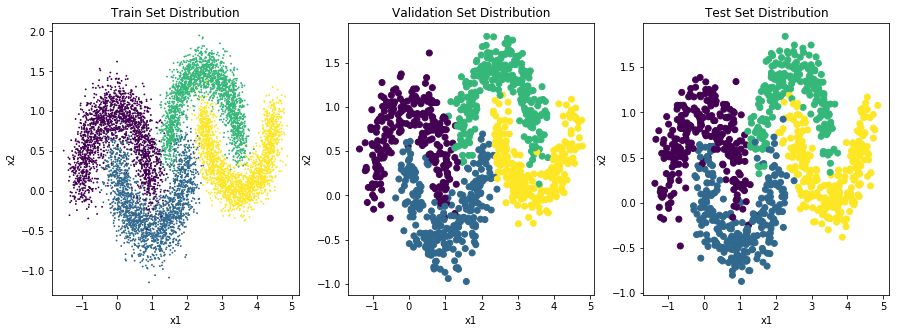

In [58]:
# ====== Generating Dataset ====== #
Xmoon1, ymoon1 = make_moons(5000, noise=0.2, random_state=2)
Xmoon2, ymoon2 = make_moons(5000, noise=0.15, random_state=0)
Xmoon2 = Xmoon2 + np.array([2.5, 0.5])
ymoon2 = ymoon2 + 2

X = np.concatenate((Xmoon1, Xmoon2))
y = np.concatenate((ymoon1, ymoon2))
y = y.reshape(-1, 1)
dataset = np.concatenate((X, y), axis=1)
np.random.shuffle(dataset)
X = dataset[:, :2]
y = dataset[:, 2]


# ====== Split Dataset into Train, Validation, Test ======#
train_X, train_y = X[:8000, :], y[:8000]
val_X, val_y = X[8000:9000, :], y[8000:9000]
test_X, test_y = X[9000:, :], y[9000:]
print(X.shape, y.shape)

# ====== Visualize Each Dataset ====== #
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')


ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')

plt.show()

### 2. Hypothesis Define (Model Define)  

Linear Regression 시에 활용하는 H(x) = Wx + b를 파이토치로 구현할 때는 단순하게 `nn.Linear` 모듈을 하나 만들어주면 됩니다. 이 때`in_features`는 x의 차원이고, `out_features`는 y의 차원입니다.  



**Multi-Label Logistic Model**   
$$z = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 4}, b \in \mathcal{R}^{4}, z \in \mathcal{R}^{N \times 4}$$  
$$H = \ softmax(z) \ \ (  H \in \mathcal{R}^{N \times 4})$$  


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200}$$  

$$z = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 4}, b_2 \in \mathcal{R}^{4}, z \in \mathcal{R}^{N  \times 4})$$  

$$H = \ softmax(z) \ \ ( H \in \mathcal{R}^{N \times 4})$$  


In [ ]:
import torch
import torch.nn as nn


class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=1, bias=True)
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        return self.linear(x)
    
    
class MLPModel(nn.Module):
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
    # 인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴합니다.
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

### 3. Cost Function Define (Loss Function Define)  

Regression Problem 에서의 Loss Function을 작성해봅시다.  
파이토치의 `nn` 아래에는 다양한 Loss Function이 이미 구현되어 있습니다.  
[여기](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html)에서 파이토치 내부에 구현되어 있는 MSE, Cross-Entropy, KL-Divergence 등을 확인할 수 있습니다.  
이 실습에서는 Regression Problem 이므로 Mean Squared Error 즉 MSE Loss를 써봅시다.

In [ ]:
reg_loss = nn.MSELoss()

test_pred_y = torch.Tensor([0,0,0,0])
test_true_y = torch.Tensor([0,1,0,1])

print(reg_loss(test_pred_y, test_true_y))
print(reg_loss(test_true_y, test_true_y))

### 4. Train & Monitor Training Process  
이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜볼까요?  
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.  
`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.  
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다.  

In [ ]:
import torch.optim as optim


# model = LinearModel()
# print(model.linear.weight)
# print(model.linear.bias)

model = MLPModel() # Model을 생성해줍니다.
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad))) # 복잡해보이지만 간단히 모델 내에 학습을 당할 파라미터 수를 카운팅하는 코드입니다.

lr = 0.005 # Learning Rate를 하나 정해줍니다. (원할한 학습을 위해 손을 많이 탑니다)
optimizer = optim.SGD(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.
# optimizer = optim.Adam(model.parameters(), lr=lr) # Optimizer를 생성해줍니다.

# 매 학습 단계에서의 epoch값과 그 때의 loss 값을 저장할 리스트를 만들어줍시다.
list_epoch = [] 
list_loss = []

epoch = 4000 # 학습 횟수(epoch)을 지정해줍시다.
for i in range(epoch):
    
    model.train()
    optimizer.zero_grad()
    
    input_x = torch.Tensor(X)
    true_y = torch.Tensor(y)
    pred_y = model(input_x)
#     print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원을 체크해봅니다.
    
    loss = reg_loss(pred_y.squeeze(), true_y)
    loss.backward() # backward()를 통해서 그라디언트를 구해줍니다.
    optimizer.step() # step()을 통해서 그라디언틀르 바탕으로 파라미터를 업데이트 해줍니다. 

    list_epoch.append(i)
    list_loss.append(loss.detach().numpy())
    
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        fig = plt.figure(figsize=(9,5))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.scatter(X[:, 0], X[:, 1], y, c=y, cmap='jet')
        
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_zlabel('y')
        ax1.set_zlim(-10, 6)
        ax1.view_init(40, -40)
        ax1.invert_xaxis()

        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.scatter(X[:, 0], X[:, 1], pred_y.detach().numpy(), c=pred_y.detach().numpy()[:,0], cmap='jet') #, c=y)#, cmap='jet')

        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_zlabel('y')
        ax2.set_zlim(-10, 6)
        ax2.view_init(40, -40)
        ax2.invert_xaxis()
        
        plt.show()
        print(i, loss)

In [ ]:
plt.plot(list_epoch, list_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
# plt.ylim(0, 100)
plt.grid()
plt.show()